In [1]:
import pandas as pd

In [2]:
import pytz
tz = pytz.timezone('Pacific/Auckland')

# Data

Coming from [linz](https://www.linz.govt.nz/sea/tides/tide-predictions)

In [3]:
colName = ["Day", "Day of the week", "Month", "Year", "Tide 1 Time", "Tide 1 Height", "Tide 2 Time", "Tide 2 Height", "Tide 3 Time", "Tide 3 Height", "Tide 4 Time", "Tide 4 Height"]

In [4]:
data = pd.read_csv("Nelson 2018.csv", sep=",", header=None, encoding = "utf-8", skiprows=3, names=colName)

In [5]:
data.head()

,Day,Day of the week,Month,Year,Tide 1 Time,Tide 1 Height,Tide 2 Time,Tide 2 Height,Tide 3 Time,Tide 3 Height,Tide 4 Time,Tide 4 Height
0,1,Mo,1,2018,03:23,0.7,09:58,4.1,15:56,0.5,22:06,4.1
1,2,Tu,1,2018,04:19,0.5,10:48,4.4,16:46,0.3,23:00,4.3
2,3,We,1,2018,05:11,0.4,11:35,4.5,17:34,0.3,23:51,4.3
3,4,Th,1,2018,06:00,0.3,12:21,4.5,18:22,0.3,NaN,NaN
4,5,Fr,1,2018,00:41,4.3,06:46,0.4,13:06,4.4,19:11,0.4


# Preproc

In [6]:
from datetime import datetime, date, time, timedelta

In [7]:
d = []
h = []
lt = []

for i, r in data.iterrows() :
    
    for t in range(1, 5) :
        
        if not pd.isna(r['Tide ' + str(t) + ' Height']) :
            d.append(tz.localize(datetime.strptime(str(r['Year']) + '-' + str(r['Month'])  + '-' + str(r['Day']) + ' ' + r['Tide ' + str(t) + ' Time'], "%Y-%m-%d %H:%M")))
            h.append(float(r['Tide ' + str(t) + ' Height']))
        
            if len(lt) > 0 and h[-1] < h[-2] :
                lt.append(True)
                
            else :
                lt.append(False)
                
lt[0] = h[0] < h[1]

df = pd.DataFrame({'height' : h, 'low tide' : lt}, index = d)

In [8]:
df.head()

,height,low tide
2018-01-01 03:23:00+13:00,0.7,True
2018-01-01 09:58:00+13:00,4.1,False
2018-01-01 15:56:00+13:00,0.5,True
2018-01-01 22:06:00+13:00,4.1,False
2018-01-02 04:19:00+13:00,0.5,True


In [9]:
df.index.dtype

datetime64[ns, Pacific/Auckland]

# To find the height of the tide at a given time

If $t_1$ and $h_1$ denote the time and height of the tide (high or low) immediately preceeding time $t$, and $t_2$ and $h_2$ denote the height of the tide (high or low) immediately following time $t$, then the height $h$ at time $t$ is given by the following formula:  

$h = h_1 + (h_2 - h_1 )[(cosA + 1)/2]$  
where $A = π ([(t - t_1 )/(t_2 - t_1 )] + 1)$ radians  
Note 1: On falling tides $(h_2 - h_1 )$ will be negative.  
Note 2: t , $t_1$ and $t_2$ are in decimal hours.  

from [Linz](https://www.linz.govt.nz/sea/tides/tide-predictions/how-calculate-tide-times-heights)

## Calculation

In [10]:
import numpy as np

In [11]:
# Start stop date
t_start = datetime.now(tz) - timedelta(days=1)
t_stop = datetime.now(tz) + timedelta(days=1)

In [12]:
# Convert into indexs
i_start = df.index.get_loc(t_start, method='pad')
i_stop = df.index.get_loc(t_stop, method='backfill')

In [13]:
tides = pd.DataFrame()

# And then we loop
for i in range(i_start, i_stop) :
    # Tides time and height
    t1 = df.index[i]
    t2 = df.index[i + 1]
    h1 = df['height'][i]
    h2 = df['height'][i + 1]

    #t = np.arange(t1, t2, timedelta(seconds=1))
    t = pd.date_range(start = t1, end = t2, freq = timedelta(seconds=1))
    
    #t1 = df.index[i].tz_localize(None).to_pydatetime()
    #t2 = df.index[i + 1].tz_localize(None).to_pydatetime()
    #t = np.arange(t1, t2, timedelta(seconds=1)).astype(datetime)
    
    # Calculation
    A = np.pi * ((t - t1) / (t2 - t1) + 1).astype(float)
    h = h1 + (h2 - h1) * ((np.cos(A) + 1) / 2)
    
    # Add to the dataframe
    tides = tides.append(pd.DataFrame({'height' : h}, index=t))

In [14]:
tides.head()

,height
2018-04-20 18:41:00+12:00,0.7
2018-04-20 18:41:01+12:00,0.7
2018-04-20 18:41:02+12:00,0.7
2018-04-20 18:41:03+12:00,0.7
2018-04-20 18:41:04+12:00,0.7


## Plot

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [16]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['timezone'] = 'Pacific/Auckland'

In [17]:
# Subset
pltdata = tides.loc[(tides.index > t_start) & (tides.index < t_stop)]

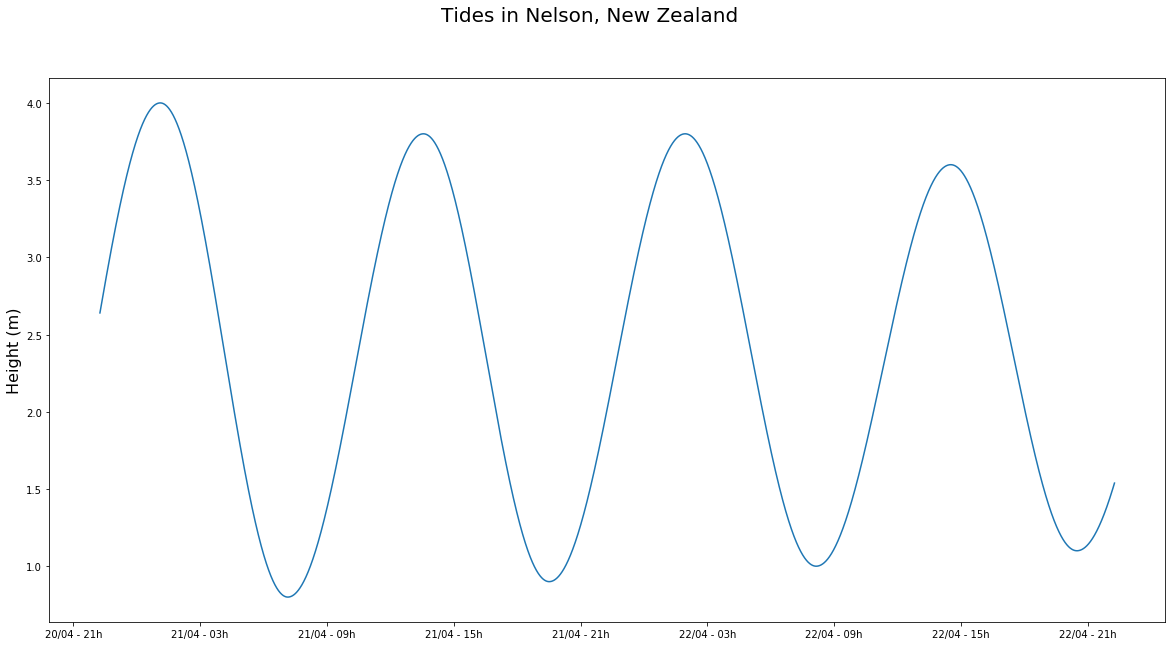

In [18]:
fig = plt.figure()
fig.suptitle('Tides in Nelson, New Zealand', fontsize=20)

ax = fig.add_subplot(1, 1, 1)
ax.plot(pltdata)

#ax.set_xlabel('Datetime', fontsize=18)
ax.set_ylabel('Height (m)', fontsize=16)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m - %Hh')
ax.xaxis.set_major_formatter(myFmt)

plt.show()